# Test Ellipse Fit 2

## Imports

In [1]:
# Python standard library
import sys
import csv
import os

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append(r'C:\Users\Aaron\Desktop\Research_Stuff\GitHub\pore_stats\pore_stats/rp/')
sys.path.append(r'C:\Users\Aaron\Desktop\Research_Stuff\GitHub\pore_stats\pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Load Data

In [2]:
date = '8-23-2017/'
particle = '293-T/'
channel = '15-30-15_3/'
file_index = '2'

base_path = r'G:\Research_Stuff\cells\cancer/'
analysis_path = r'C:\Users\Aaron\Desktop\Research_Stuff\Data_Analysis/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events' + '.json'

In [3]:
# Load video
res_x = 512
res_y = 288
oi_fps = 100000
exposure = 5
oi_vid = oi_file.Video(oi_vid_file_path, res_x, res_y, oi_fps, exposure)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

print 'loaded', len(oi_events), 'oi events'

C:\Users\Aaron\Desktop\Research_Stuff\GitHub\pore_stats\pore_stats/oi/optical_imaging.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


loaded 1078 oi events


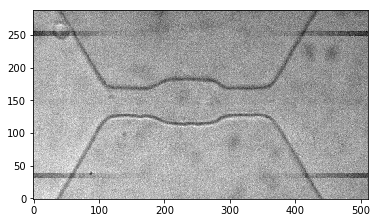

In [4]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[-0.  1.]


C:\Users\Aaron\Desktop\Research_Stuff\GitHub\pore_stats\pore_stats/oi/optical_imaging.py:429: RuntimeWarning: divide by zero encountered in double_scalars
  plt.plot([x, x + image_height/(self._norm_y[1]/self._norm_y[0])], [0, image_height], ls = '--', color = 'yellow')


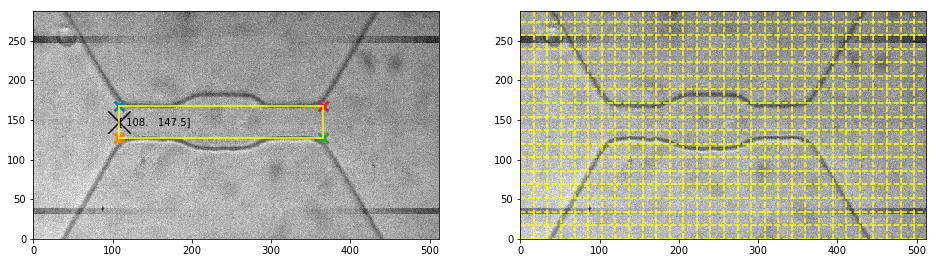

In [5]:
reload(oi)
template_frame = oi_vid.get_frame(template_index)
c0 = [108,168]
c1 = [108,127]
c2 = [365,127]
c3 = [365,168]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Define Plotting Functions

In [6]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()

def find_width_height(processed_frame):
    width = 0
    height = 0
    for i in range(len(processed_frame)):
        w = calculate_distance_list(processed_frame[i])
        if w > width:
            width = w
    for i in range(len(processed_frame[0])):
        l = []
        for j in range(len(processed_frame)):
            l.append(processed_frame[j][i])
        h = calculate_distance_list(l)
        if h > height:
            height = h
    
    return width, height

def calculate_distance_list(l):
    min_pos = 0
    max_pos = 0
    for i in range(len(l)):
        if l[i] > 0:
            if min_pos == 0:
                min_pos = i
            else:
                max_pos = i
    return abs(max_pos-min_pos)
                
        

## Preprocess Functions

To add function, make its input include a dict (data_dict) which will contain all frames and variables.  Set the return value to be a dict with any changed frames, values, and info to make a note of the step.  Put function name in list of function (steps).

In [7]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

def copy(data_dict, debug = 'none'):
    raw_frame = data_dict['raw_frame']
    raw_template_frame = data_dict['raw_template_frame']
    processed_template_frame = np.copy(raw_template_frame)
    processed_frame = np.copy(raw_frame)
    
    if debug == 'all':
        print 'copy'
        plot_all(processed_frame, raw_frame)
    
    return {'processed_template_frame' : processed_template_frame, 'processed_frame' : processed_frame,\
           'info':'copy'}

        
def crop(data_dict, debug = 'none'):
    processed_frame = data_dict['processed_frame']
    processed_template_frame = data_dict['processed_template_frame']
    detection = data_dict['detection']
    crop_distance = 30
    processed_frame = crop_frame(processed_frame, detection._px, detection._py, crop_distance)
    processed_template_frame = crop_frame(processed_template_frame, detection._px, detection._py, crop_distance)
    frame = np.copy(processed_frame)

    if debug == 'all':
        print 'crop'
        plot_all(processed_frame, frame)
    
    return {'processed_frame' : processed_frame, 'processed_template_frame' : processed_template_frame, 'frame' : frame,\
           'crop_distance': crop_distance, 'info':'crop: distance={}'.format(crop_distance)}

        
def blur(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    processed_template_frame = data_dict['processed_template_frame']
    blur_kernel = data_dict['blur_kernel']
    
    #blur_kernel = (11,11)    # 19
    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)
    processed_template_frame = cv2.GaussianBlur(processed_template_frame, blur_kernel, 0)
    
    if debug == 'all':
        print 'gaussian blur'
        plot_all(processed_frame, frame)
    
    return {'processed_frame' : processed_frame, 'processed_template_frame' : processed_template_frame,\
           'info':'blur: kernel={}'.format(blur_kernel)}

        
def negative(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    processed_template_frame = data_dict['processed_template_frame']
    processed_frame = processed_template_frame - processed_frame

    if debug == 'all':
        print 'processed-template negative'
        plot_all(processed_frame, frame)
    
    return {'processed_frame' : processed_frame, 'info':'negative'}
        
        
def gradient(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    processed_frame = cv2.Laplacian(processed_frame, cv2.CV_64F)

    if debug == 'all':
        print 'gradient'
        plot_all(processed_frame, frame)
    
    return {'processed_frame' : processed_frame, 'info':'gradient'}

def inversion(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    processed_frame = 1-processed_frame

    if debug == 'all':
        print 'inversion'
        plot_all(processed_frame, frame)
    
    return {'processed_frame' : processed_frame, 'info':'inversion'}


def rescale(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))

    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)
    
    return {'processed_frame' : processed_frame, 'info':'rescale'}


def adaptive_thresholding_histogram_derivative(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    sigma = data_dict['sigma']
    threshold_factor = data_dict['threshold_factor']
               
    total_bins = 100

    counts, bins = np.histogram(processed_frame, bins = 100)
    
    smoothed_counts = scipy.ndimage.filters.gaussian_filter(counts, sigma = 3)

    derivative_smoothed_counts = np.gradient(smoothed_counts)

    derivative_threshold = np.abs(np.min(derivative_smoothed_counts)/threshold_factor)

    for i in range(len(derivative_smoothed_counts)):
        if np.abs(derivative_smoothed_counts[-1-i]) > derivative_threshold:
            index = -1-i
            break
            
    threshold = (bins[index] + bins[index-1])/2.

    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0
    processed_frame = processed_frame.astype(int)
    
    if debug == 'all':
        print 'adaptive thresholding histogram derivative, sigma = ', sigma, 'derivative threshold = half max'
        plot_all(processed_frame, frame)
    
    return {'processed_frame' : processed_frame,\
            'info':'adaptive_thresholding_histogram_derivative: sigma={} threhold_factor={}'.format(sigma, threshold_factor)}


def cluster_filtering(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    cluster_threshold = data_dict['cluster_threshold']

    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True, cluster_threshold = cluster_threshold)
    
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for cluster in clusters:
        for pixel in cluster:
            processed_frame[pixel[0], pixel[1]] = 1


    if debug == 'all':
        print 'cluster threshold', cluster_threshold
        plot_all(processed_frame, frame)
    
    return {'processed_frame' : processed_frame, 'info':'cluster_filtering: cluster_threshold={}'.format(cluster_threshold)}


def percentage_based_cluster_filtering(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    percentage_of_largest = data_dict['percentage_of_largest']
    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)

    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]

    cluster_threshold =  int(len(largest_cluster) * percentage_of_largest)
    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True, cluster_threshold = cluster_threshold)
    
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for cluster in clusters:
        for pixel in cluster:
            processed_frame[pixel[0], pixel[1]] = 1
            
    if debug == 'all':
        print 'percentage based cluster threshold', percentage_of_largest
        plot_all(processed_frame, frame)
    
    return {'processed_frame' : processed_frame,\
           'info':'percentage_based_cluster_filtering: percentage_of_largest={}'.format(percentage_of_largest)}


def pad(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    pad_width = data_dict['pad_width']
    processed_frame = np.lib.pad(processed_frame, pad_width, 'constant')
       
    if debug == 'all':
        print 'pad'
        plot_all(processed_frame, frame)
        
    return {'processed_frame' : processed_frame, 'info':'pad: pad_width={}'.format(pad_width)}


def morphological_closing(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    morph_kernel_size = data_dict['morph_kernel_size']
    #morph_kernel_size = (45,45) #15

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)

    if debug == 'all':
        print 'morphological closing'
        plot_all(processed_frame, frame)

    return {'processed_frame':processed_frame, 'info':'morphological closing, kernel={}'.format(morph_kernel_size)}


def unpad(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    pad_width = data_dict['pad_width']
    processed_frame = processed_frame[pad_width:-pad_width, pad_width:-pad_width]
       
    if debug == 'all':
        print 'unpad'
        plot_all(processed_frame, frame)
    
    return {'processed_frame':processed_frame, 'info':'unpad: pad_width={}'.format(pad_width)}


def erode_subtraction(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    iterations = data_dict['iterations']

    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)

    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
        
    return {'processed_frame':processed_frame, 'info':'erosion subtraction: iterations={}'.format(iterations)}


def fit_ellipse(data_dict, debug = 'none'):
    frame = data_dict['frame']
    processed_frame = data_dict['processed_frame']
    detection = data_dict['detection']
    crop_distance = data_dict['crop_distance']
    
    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[1], cell_pixels[0])

    # Center
    ellipse_center = oi.get_ellipse_center(ellipse)
    ellipse_center_adjusted = [ellipse_center[0] + detection._px - crop_distance, ellipse_center[1] + detection._py - crop_distance]

    # Axes
    ellipse_axes_lengths = oi.get_ellipse_axes_lengths(ellipse)
    
    # Angle
    ellipse_angle = oi.get_ellipse_angle(ellipse)

    
    
    if debug != 'none':
        # Create perimeter line
        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes_lengths[0]*np.cos(angle)
            y = ellipse_axes_lengths[1]*np.sin(angle)
            ellipse_points[i,0] = ellipse_center[0] + np.cos(ellipse_angle)*x + np.sin(ellipse_angle)*y
            ellipse_points[i,1] = ellipse_center[1] + np.sin(ellipse_angle)*x - np.cos(ellipse_angle)*y

        # Turn pixels green
        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame

        # Begin plot
        fig, axes = plt.subplots(1,3,figsize = (12,3))
        
        
        # Axes 0
        plt.sca(axes[0])
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])

        
        # Axes 1
        plt.sca(axes[1])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        #plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        #plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', lw = 5, color = 'red', s = 50)
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        
        # Axes 2
        plt.sca(axes[2])
        
        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        #plt.imshow(processed_frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 3, c = 'red')

        plt.scatter(ellipse_center[0], ellipse_center[1], marker = 'x', c = 'red', lw = 3, s = 20)
        
        
        ellipse_axis_a = [ellipse_axes_lengths[0]*np.cos(ellipse_angle), ellipse_axes_lengths[0]*np.sin(ellipse_angle)]
        ellipse_axis_b = [ellipse_axes_lengths[1]*np.sin(ellipse_angle), -ellipse_axes_lengths[1]*np.cos(ellipse_angle)]

        
        ax0 = ellipse_center[0]
        ax1 = ax0 + ellipse_axis_a[0]
        ay0 = ellipse_center[1]
        ay1 = ay0 + ellipse_axis_a[1]
        
        bx0 = ellipse_center[0]
        bx1 = bx0 + ellipse_axis_b[0]
        by0 = ellipse_center[1]
        by1 = by0 + ellipse_axis_b[1]
        
        plt.plot([ax0, ax1], [ay0, ay1], lw = 3, c = 'red')
        plt.plot([bx0, bx1], [by0, by1], lw = 3, c = 'red')
        
        plt.text((ax0+ax1)/2., (ay0+ay1)/2., 'a', color = 'red', size = 20, ha = 'left', va = 'bottom')
        plt.text((bx0+bx1)/2., (by0+by1)/2., 'b', color = 'red', size = 20, ha = 'left', va = 'bottom')
        
        plt.text(1, 0.2, r'$|a|=$'+str(round(ellipse_axes_lengths[0],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')
        plt.text(1, 0.1, r'$|b|=$'+str(round(ellipse_axes_lengths[1],3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')

        plt.text(1, 0, r'$\theta=$'+str(round(ellipse_angle*180./np.pi,3)), transform=plt.gca().transAxes, ha = 'right', va = 'bottom', size = 12, color = 'red')
        
        
        
        plt.xlim(0, processed_frame.shape[1])
        plt.ylim(0, processed_frame.shape[0])
        
        plt.grid()
        
        
        plt.show()
        

        
    return [ellipse_center_adjusted[0], ellipse_center_adjusted[1], ellipse_axes_lengths[0], ellipse_axes_lengths[1], ellipse_angle]

In [8]:
def process_steps(data_dict, steps, debug = 'none'):
    preprocessing_steps = []
    for item in steps:
        if type(item)is tuple:
            data_dict[item[0]] = item[1]
            if debug == 'all':
                print '{} changed to {}'.format(item[0], item[1])
        else:
            return_dict = item(data_dict, debug)
            for key in return_dict.keys():
                if key == 'info':
                    preprocessing_steps.append(return_dict['info'])
                else:
                    data_dict[key] = return_dict[key]
    data_dict['preprocessing_steps'] = preprocessing_steps
    return data_dict

## Find Event

In [9]:
# Video
oi_index = 2
oi_event = oi_events[oi_index]
reload(oi_file)
plt.close()

add_frames = 4
HTML(oi_file.make_animation(oi_vid, oi_event._detections[0]._tf, oi_event._detections[-1]._tf + add_frames, oi_fps).to_html5_video())

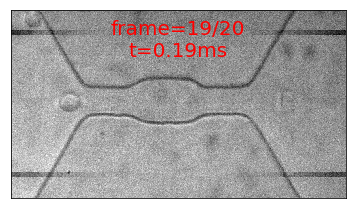

In [10]:
# Image
oi_index = 2
oi_event = oi_events[oi_index]
ts = oi_event.get_tf()
t = int((ts[-1] + ts[0])/2.)
frame = oi_vid.get_frame(t)
plt.imshow(frame, cmap = 'gray', origin = 'lower')
plt.show()

## Steps and Variables

In [11]:
# steps list contain the function names in the order to be executed
steps = [copy, crop, blur, negative, gradient, inversion, rescale, adaptive_thresholding_histogram_derivative,\
        cluster_filtering,  pad, morphological_closing, unpad, erode_subtraction]
#percentage_based_cluster_filtering,
# add 2-tuple to change variable, (str(name_of_var), value)

In [12]:
# Variables
data_dict = dict()

debug = 'all'

# Blur Kernel
data_dict['blur_kernel'] = (9,9)

# Adaptive Thresholding Histogram Derivative
#    sigma
data_dict['sigma'] = 3
#    threshold
data_dict['threshold_factor'] = 1.5

# Cluster Threshold
data_dict['cluster_threshold'] = 20

# Percentage Cluster
data_dict['percentage_of_largest'] = .15

# Pad
data_dict['pad_width'] = 20

# Morph
data_dict['morph_kernel_size'] = (45, 45)

# Erode Subtraction Iterations
data_dict['iterations'] = 3

## Process

copy


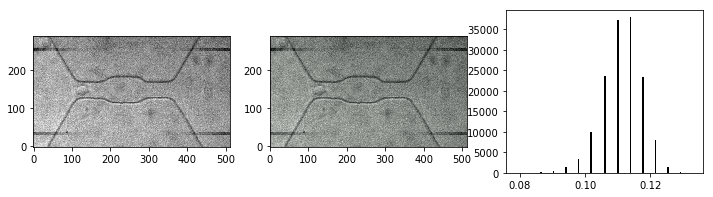

crop


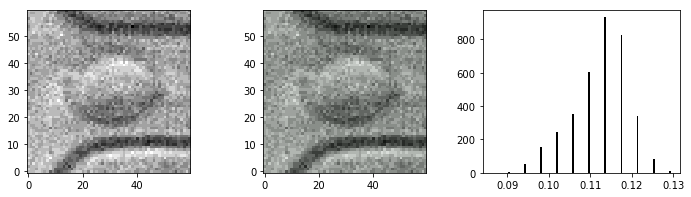

gaussian blur


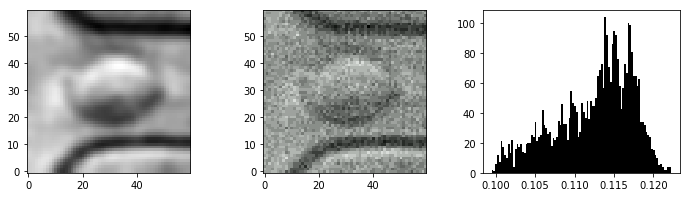

processed-template negative


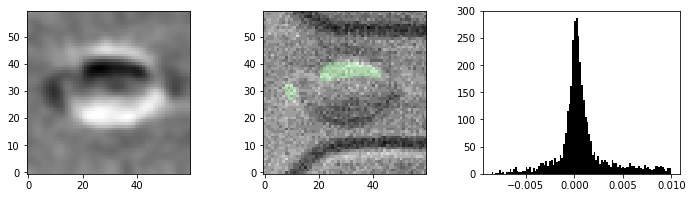

gradient


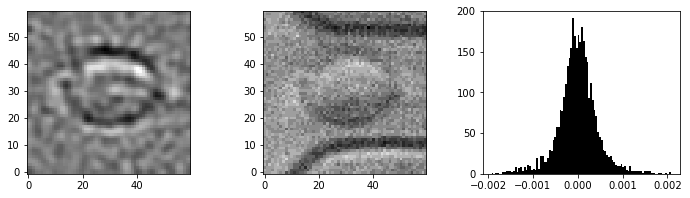

inversion


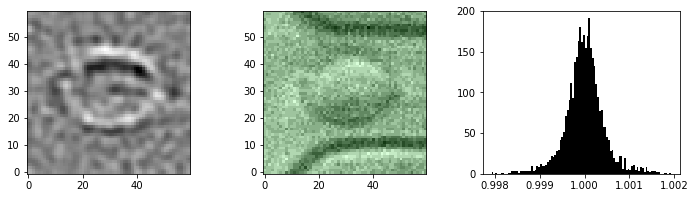

rescale


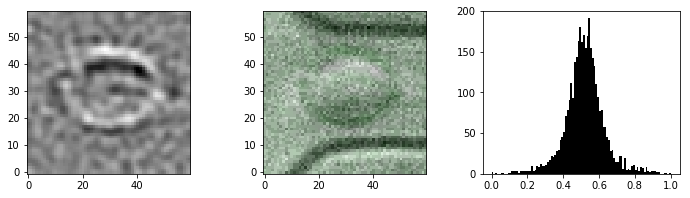

adaptive thresholding histogram derivative, sigma =  3 derivative threshold = half max


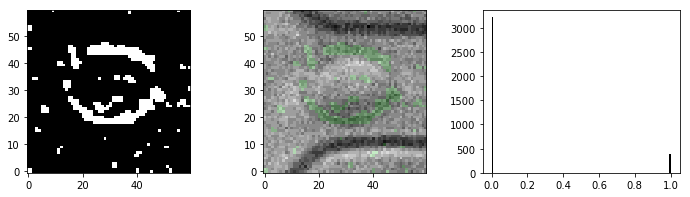

cluster threshold 20


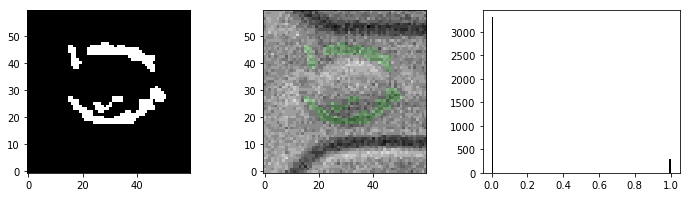

pad


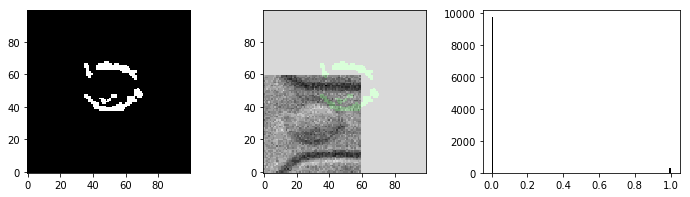

morphological closing


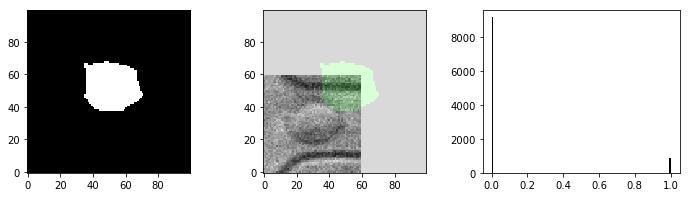

unpad


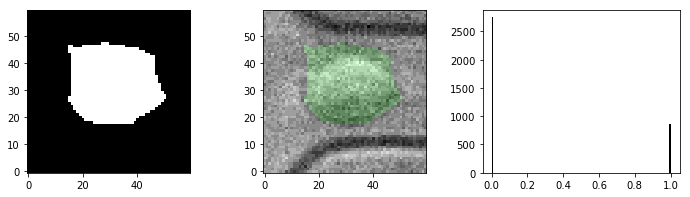

erode subtraction


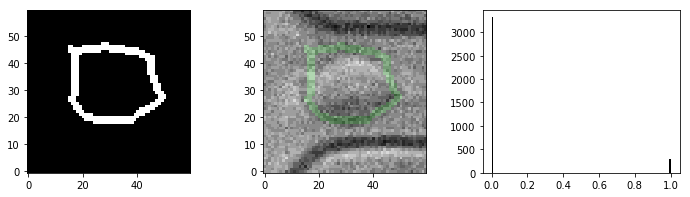

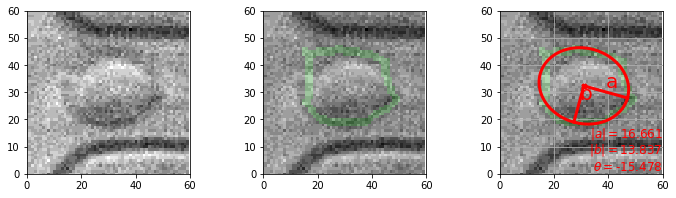

126.598442372 148.561565288


In [13]:
xs = oi_event.get_px()
ys = oi_event.get_py()
xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
xcs = oi_stage.pixels_to_meters(xcs)

xc_left = 0
xc_right = 30
data_dict['raw_template_frame'] = template_frame

for j, detection in enumerate(oi_event._detections):
    try:
        if xcs[j] >= xc_left and xcs[j] <= xc_right:
            
            # Get raw frame
            raw_frame = oi_vid.get_frame(detection._tf)
            
            # Set
            data_dict['raw_frame'] = raw_frame
            data_dict['detection'] = detection
            return_dict = process_steps(data_dict, steps, debug)
            
            # Get ellipse/preprocess the frame
            ellipse = fit_ellipse(return_dict, debug)
            
            print ellipse[0], ellipse[1]
            
    except Exception as e:
        print 'failed on ', j, len(oi_event._detections)
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print(exc_type, fname, exc_tb.tb_lineno)
        pass

preprocessing_steps = data_dict['preprocessing_steps']

In [1]:
jasd;lkjf;ldsaf

NameError: name 'jasd' is not defined

In [2]:
R_glass = 10**(-2.)/(200*10**(-9.))**2.
R_sin = 50*10**(-9.)/(5*10**(-9.))**2.

print R_glass/R_sin

125.0
